# 🧪 Super Resolución Clásica - Técnicas en Python
Este notebook muestra implementaciones prácticas de cinco técnicas clásicas de super resolución: 
1. Interpolación bilineal, bicúbica, por area y lanczos
2. Iterative Back-Projection (IBP)
3. Non-Local Means Super-Resolution
4. Edge-Guided Interpolation (EGI)
5. Frequency Domain Extrapolation

In [1]:
import os
import cv2
import glob
import time
import tracemalloc
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple
from skimage import img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

## Profiling helper wrappers

In [2]:
def time_algorithm(func, *args, **kwargs):
    """Return (result, elapsed_seconds) executing only the algorithm body."""
    start = time.perf_counter()
    result = func(*args, **kwargs)
    elapsed = time.perf_counter() - start
    return result, elapsed

def memory_algorithm(func, *args, **kwargs):
    """Return (result, peak_bytes) measuring memory (peak) for the algorithm body."""
    tracemalloc.start()
    result = func(*args, **kwargs)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return result, peak

def profile_algorithm(func, *args, **kwargs):
    """Convenience wrapper returning (result, elapsed_seconds, peak_bytes).
    Uses tracemalloc to capture peak memory and perf_counter for timing.
    """
    tracemalloc.start()
    start = time.perf_counter()
    result = func(*args, **kwargs)
    elapsed = time.perf_counter() - start
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return result, elapsed, peak

## Tracking structures for profiling data

In [3]:
time_stats_algorithms = {
    'bilinear': [], 'bicubic': [], 'area': [], 'lanczos': [],
    'ibp': [], 'nlm': [], 'egi': [], 'freq': []
}
memory_stats_algorithms = {k: [] for k in time_stats_algorithms.keys()}

## Loading dataset

In [4]:
HR_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/HR/low_z_offset"))
LR_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/LR/low_z_offset"))

hr_paths = sorted(glob.glob(os.path.join(HR_DIR, '*.png')))
lr_paths = sorted(glob.glob(os.path.join(LR_DIR, '*.png')))

assert len(hr_paths) == len(lr_paths) and len(hr_paths) > 0, "No HR/LR pairs found or the number does not match"

# Load all images into memory (if possible); otherwise, process in streaming
hr_images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in hr_paths]
lr_images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in lr_paths]

example_index = 0

## 1. Interpolación bilineal, bicúbica, por area y lanczos

In [5]:
def run_all_interpolations(lr_img, target_shape: Tuple[int, int]):
    """Run all four interpolation methods returning dict of images.
    This does NOT include any metric computation (PSNR/SSIM).
    """
    
    return {
        'bilinear': 
            cv2.resize(lr_img, target_shape, interpolation=cv2.INTER_LINEAR),
        'bicubic': 
            cv2.resize(lr_img, target_shape, interpolation=cv2.INTER_CUBIC),
        'area': 
            cv2.resize(lr_img, target_shape, interpolation=cv2.INTER_AREA),
        'lanczos': 
            cv2.resize(lr_img, target_shape, interpolation=cv2.INTER_LANCZOS4),
    }

In [6]:
psnr_stats = {"bilinear": [], "bicubic": [], "area": [], "lanczos": []}
ssim_stats = {"bilinear": [], "bicubic": [], "area": [], "lanczos": []}

for idx, (hr_img, lr_img) in enumerate(zip(hr_images, lr_images)):
    h, w = hr_img.shape[:2]

    # --- Profile interpolation algorithms (time & memory) ---
    def _interp_bundle():
        return run_all_interpolations(lr_img, (w, h))
    
    # Time
    interp_results, elapsed = time_algorithm(_interp_bundle)
    for name, img_res in interp_results.items():
        time_stats_algorithms[name].append(elapsed)

    # Memory
    interp_results_mem, peak_mem = memory_algorithm(_interp_bundle)
    for name in interp_results_mem.keys():
        memory_stats_algorithms[name].append(peak_mem)

    bilinear = interp_results['bilinear']
    bicubic = interp_results['bicubic']
    area = interp_results['area']
    lanczos = interp_results['lanczos']

    # Metrics
    hr_f = hr_img.astype(np.float32) / 255.0
    bilinear_f = bilinear.astype(np.float32) / 255.0
    bicubic_f = bicubic.astype(np.float32) / 255.0
    area_f = area.astype(np.float32) / 255.0
    lanczos_f = lanczos.astype(np.float32) / 255.0

    psnr_stats["bilinear"].append(psnr(hr_f, bilinear_f, data_range=1.0))
    psnr_stats["bicubic"].append(psnr(hr_f, bicubic_f, data_range=1.0))
    psnr_stats["area"].append(psnr(hr_f, area_f, data_range=1.0))
    psnr_stats["lanczos"].append(psnr(hr_f, lanczos_f, data_range=1.0))

    ssim_stats["bilinear"].append(ssim(hr_f, bilinear_f, channel_axis=2, data_range=1.0))
    ssim_stats["bicubic"].append(ssim(hr_f, bicubic_f, channel_axis=2, data_range=1.0))
    ssim_stats["area"].append(ssim(hr_f, area_f, channel_axis=2, data_range=1.0))
    ssim_stats["lanczos"].append(ssim(hr_f, lanczos_f, channel_axis=2, data_range=1.0))

    # Save for visualization if it's the chosen example
    if idx == example_index:
        vis = (hr_img, lr_img, bilinear, bicubic, area, lanczos)

#### Evaluation

In [7]:
print("Interpolation - Average metrics (PSNR dB / SSIM):")
for k in psnr_stats.keys():
    print(f"  {k.capitalize():8s} -> PSNR: {np.mean(psnr_stats[k]):.2f} dB | SSIM: {np.mean(ssim_stats[k]):.4f}")

Interpolation - Average metrics (PSNR dB / SSIM):
  Bilinear -> PSNR: 29.87 dB | SSIM: 0.7681
  Bicubic  -> PSNR: 30.02 dB | SSIM: 0.7727
  Area     -> PSNR: 29.25 dB | SSIM: 0.7475
  Lanczos  -> PSNR: 29.97 dB | SSIM: 0.7698


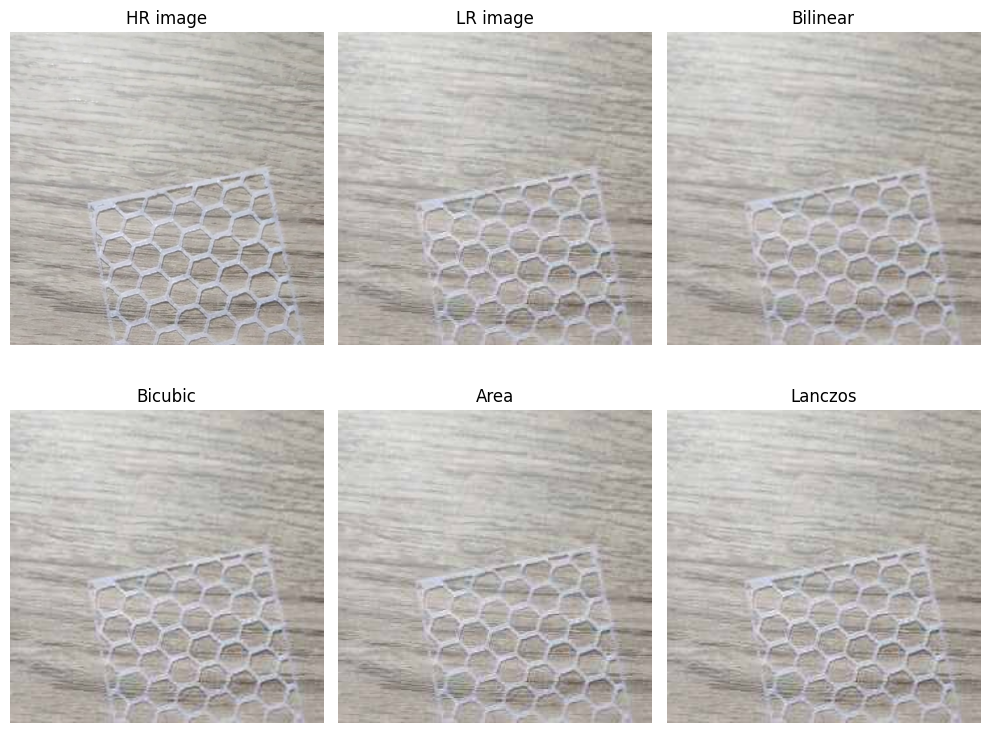

In [8]:
(hr_img_v, lr_img_v, bilinear_v, bicubic_v, area_v, lanczos_v) = vis

plt.figure(figsize=(10, 8))

plt.subplot(2, 3, 1); plt.title("HR image"); plt.imshow(hr_img_v); plt.axis('off')
plt.subplot(2, 3, 2); plt.title("LR image"); plt.imshow(lr_img_v); plt.axis('off')
plt.subplot(2, 3, 3); plt.title("Bilinear"); plt.imshow(bilinear_v); plt.axis('off')
plt.subplot(2, 3, 4); plt.title("Bicubic"); plt.imshow(bicubic_v); plt.axis('off')
plt.subplot(2, 3, 5); plt.title("Area"); plt.imshow(area_v); plt.axis('off')
plt.subplot(2, 3, 6); plt.title("Lanczos"); plt.imshow(lanczos_v); plt.axis('off')

plt.tight_layout(); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.004630355674643871..1.2650581273531756].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.005811548978727155..1.2535034781998382].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.005811548977473824..1.2966526954616062].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.005811548974705816..1.2578371394955115].


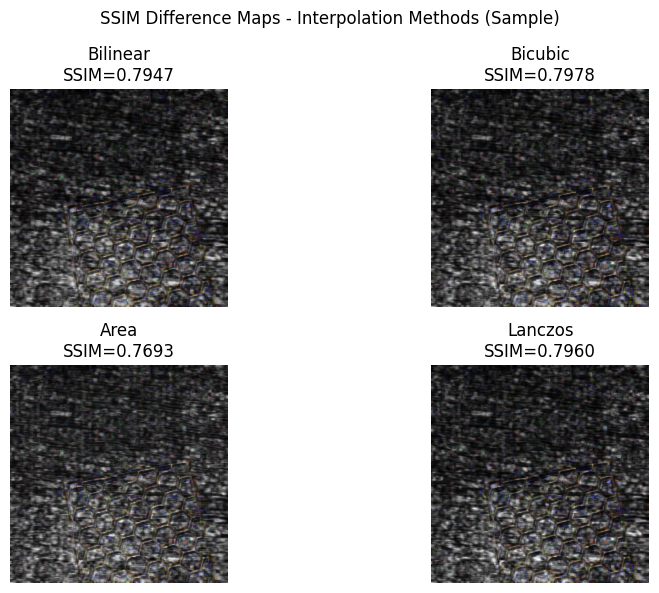

In [9]:
ssim_results = {}
for name, img in {
    'Bilinear': bilinear_v,
    'Bicubic': bicubic_v,
    'Area': area_v,
    'Lanczos': lanczos_v
}.items():
    val, ssim_map = ssim(hr_img_v, img, channel_axis=2, data_range=255, full=True)
    diff_map = 1.0 - ssim_map  # Difference (higher = more dissimilar)
    ssim_results[name] = (val, diff_map)

plt.figure(figsize=(10,6))
for i, (name, (val, diff)) in enumerate(ssim_results.items(), start=1):
    plt.subplot(2,2,i)
    plt.imshow(diff, cmap='inferno')
    plt.title(f"{name}\nSSIM={val:.4f}")
    plt.axis('off')
plt.suptitle('SSIM Difference Maps - Interpolation Methods (Sample)')
plt.tight_layout(); plt.show()

## 2. Iterative Back-Projection (IBP)

In [10]:
def back_projection(hr_image, lr_image, iterations=10):
    """Iterative Back-Projection on grayscale images."""
    hr = hr_image.astype(np.float32).copy()
    
    for _ in range(iterations):
        down = cv2.resize(hr, (lr_image.shape[1], lr_image.shape[0]), interpolation=cv2.INTER_LINEAR)
        diff = lr_image.astype(np.float32) - down
        diff_up = cv2.resize(diff, (hr.shape[1], hr.shape[0]), interpolation=cv2.INTER_LINEAR)
        hr += diff_up
        
    return np.clip(hr, 0, 255).astype(np.uint8)

In [11]:
psnr_ibp_list = []
ssim_ibp_list = []
ibp_example = None

for idx, (hr_img, lr_img) in enumerate(zip(hr_images, lr_images)):
    hr_g = cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY)
    lr_g = cv2.cvtColor(lr_img, cv2.COLOR_RGB2GRAY)

    # Profile only the IBP algorithm
    def _ibp_run():
        return back_projection(hr_g, lr_g, iterations=10)
    
    ibp_result, ibp_time = time_algorithm(_ibp_run)
    _, ibp_mem = memory_algorithm(_ibp_run)
    time_stats_algorithms['ibp'].append(ibp_time)
    memory_stats_algorithms['ibp'].append(ibp_mem)
    ibp = ibp_result
    
    # Metrics
    data_range = 255.0
    psnr_ibp_list.append(psnr(hr_g, ibp, data_range=data_range))
    ssim_ibp_list.append(ssim(hr_g, ibp, data_range=data_range))

    if idx == example_index:
        ibp_example = (hr_g, lr_g, ibp)

#### Evaluation

In [12]:
print(f"IBP - Average metrics -> PSNR: {np.mean(psnr_ibp_list):.2f} dB | SSIM: {np.mean(ssim_ibp_list):.4f}")

IBP - Average metrics -> PSNR: 31.89 dB | SSIM: 0.8464


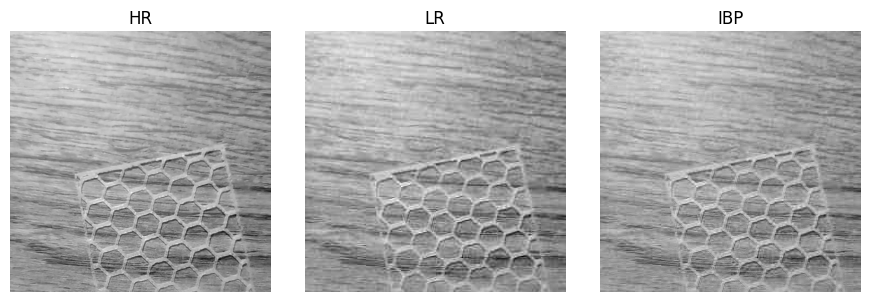

In [13]:
(hr_g_v, lr_g_v, ibp_v) = ibp_example

plt.figure(figsize=(9,3))

plt.subplot(1,3,1); plt.title("HR"); plt.imshow(hr_g_v, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title("LR"); plt.imshow(lr_g_v, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title("IBP"); plt.imshow(ibp_v, cmap='gray'); plt.axis('off')

plt.tight_layout(); plt.show()

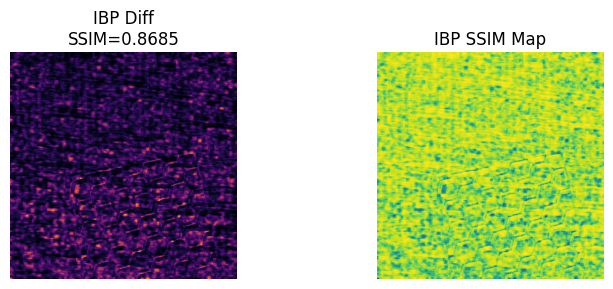

In [14]:
val_ibp, ssim_map_ibp = ssim(hr_g_v, ibp_v, data_range=255, full=True)
diff_ibp = 1.0 - ssim_map_ibp

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); plt.imshow(diff_ibp, cmap='inferno'); plt.title(f'IBP Diff\nSSIM={val_ibp:.4f}'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(ssim_map_ibp, cmap='viridis'); plt.title('IBP SSIM Map'); plt.axis('off')
plt.tight_layout(); plt.show()

## 3. Non-Local Means Super-Resolution

In [15]:
def _nlm_run(hr_g):
    sigma_est = np.mean(estimate_sigma(hr_g, channel_axis=None))
    
    return denoise_nl_means(
        img_as_float(hr_g),
        h=1.15 * sigma_est,
        patch_size=5,
        patch_distance=6,
        fast_mode=True,
    )

In [16]:
psnr_nlm_list = []
ssim_nlm_list = []
nlm_example = None

for idx, hr_img in enumerate(hr_images):
    hr_g = cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY)
    
    def _inter_nlm():
        return _nlm_run(hr_g)

    nlm_result, nlm_time = time_algorithm(_inter_nlm)
    _, nlm_mem = memory_algorithm(_inter_nlm)
    time_stats_algorithms['nlm'].append(nlm_time)
    memory_stats_algorithms['nlm'].append(nlm_mem)

    # Metrics (excluded from profiling)
    data_range = hr_g.max() - hr_g.min()
    psnr_nlm_list.append(psnr(hr_g, nlm_result, data_range=data_range))
    ssim_nlm_list.append(ssim(hr_g, nlm_result, data_range=data_range))

    if idx == example_index:
        nlm_example = (hr_g, nlm_result)

#### Evaluation

In [17]:
print(f"NLM - Average metrics -> PSNR: {np.mean(psnr_nlm_list):.2f} dB | SSIM: {np.mean(ssim_nlm_list):.4f}")

NLM - Average metrics -> PSNR: 0.33 dB | SSIM: 0.0029


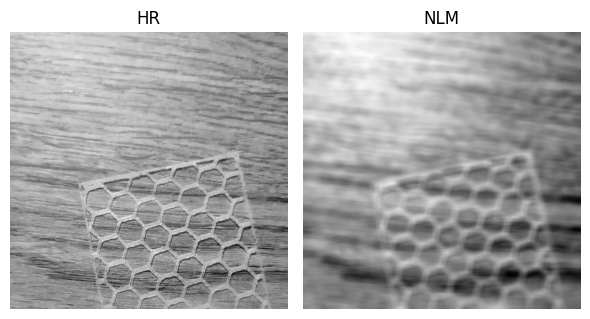

In [18]:
(hr_v, nlm_v) = nlm_example

plt.figure(figsize=(6,4))
plt.subplot(1,2,1); plt.title("HR"); plt.imshow(hr_v, cmap='gray'); plt.axis('off')
plt.subplot(1,2,2); plt.title("NLM"); plt.imshow(nlm_v, cmap='gray'); plt.axis('off')
plt.tight_layout(); plt.show()

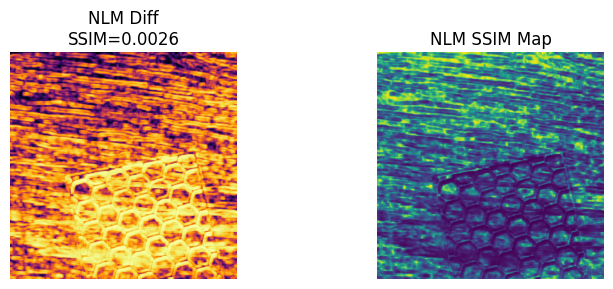

In [19]:
val_nlm, ssim_map_nlm = ssim(hr_v, nlm_v, data_range=hr_v.max()-hr_v.min(), full=True)
diff_nlm = 1.0 - ssim_map_nlm

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); plt.imshow(diff_nlm, cmap='inferno'); plt.title(f'NLM Diff\nSSIM={val_nlm:.4f}'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(ssim_map_nlm, cmap='viridis'); plt.title('NLM SSIM Map'); plt.axis('off')
plt.tight_layout(); plt.show()

## 4. Edge-Guided Interpolation (EGI)

In [20]:
def edge_guided_interpolation(ground_truth, image):
    """Edge-guided interpolation using Sobel magnitude as sharpening prior."""
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1)
    edges = np.hypot(grad_x, grad_y)

    upscaled = cv2.resize(image, (ground_truth.shape[1], ground_truth.shape[0]), interpolation=cv2.INTER_LINEAR)
    up_edges = cv2.resize(edges, (upscaled.shape[1], upscaled.shape[0]))
    sharpened = cv2.addWeighted(upscaled.astype(np.float32), 1.0, up_edges.astype(np.float32), 0.3, 0)
    
    return np.clip(sharpened, 0, 255).astype(np.uint8)

In [21]:
psnr_egi_list = []
ssim_egi_list = []
egi_example = None

for idx, (hr_img, lr_img) in enumerate(zip(hr_images, lr_images)):
    hr_g = cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY)
    lr_g = cv2.cvtColor(lr_img, cv2.COLOR_RGB2GRAY)

    def _egi_run():
        return edge_guided_interpolation(hr_g, lr_g)
    egi_res, egi_time = time_algorithm(_egi_run)
    _, egi_mem = memory_algorithm(_egi_run)
    time_stats_algorithms['egi'].append(egi_time)
    memory_stats_algorithms['egi'].append(egi_mem)
    egi_img = egi_res

    # Metrics
    data_range = 255.0
    psnr_egi_list.append(psnr(hr_g, egi_img, data_range=data_range))
    ssim_egi_list.append(ssim(hr_g, egi_img, data_range=data_range))

    if idx == example_index:
        egi_example = (hr_g, lr_g, egi_img)

#### Evaluation

In [22]:
print(f"EGI - Average metrics -> PSNR: {np.mean(psnr_egi_list):.2f} dB | SSIM: {np.mean(ssim_egi_list):.4f}")

EGI - Average metrics -> PSNR: 21.70 dB | SSIM: 0.6566


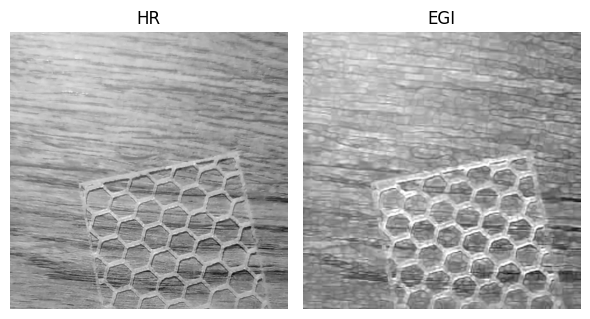

In [23]:
(hr_egi_v, lr_egi_v, egi_v) = egi_example

plt.figure(figsize=(6,4))

plt.subplot(1,2,1); plt.title("HR"); plt.imshow(hr_egi_v, cmap='gray'); plt.axis('off')
plt.subplot(1,2,2); plt.title("EGI"); plt.imshow(egi_v, cmap='gray'); plt.axis('off')

plt.tight_layout(); plt.show()

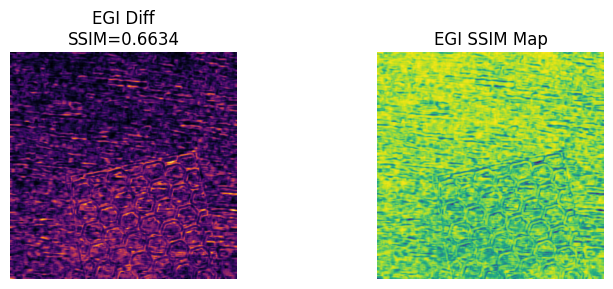

In [24]:
val_egi, ssim_map_egi = ssim(hr_egi_v, egi_v, data_range=255, full=True)
diff_egi = 1.0 - ssim_map_egi

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); plt.imshow(diff_egi, cmap='inferno'); plt.title(f'EGI Diff\nSSIM={val_egi:.4f}'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(ssim_map_egi, cmap='viridis'); plt.title('EGI SSIM Map'); plt.axis('off')
plt.tight_layout(); plt.show()

## 5. Frequency Domain Extrapolation

In [25]:
def frequency_extrapolation(ground_truth, image):
    """Frequency domain zero-padding / extrapolation of LR spectrum to HR size."""
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    
    rows, cols = image.shape
    pad_rows, pad_cols = ground_truth.shape
    f_padded = np.zeros((pad_rows, pad_cols), dtype=complex)
    center_row = pad_rows // 2
    center_col = pad_cols // 2
    half_rows = rows // 2
    half_cols = cols // 2
    
    row_start = center_row - half_rows
    row_end = row_start + rows
    col_start = center_col - half_cols
    col_end = col_start + cols

    f_padded[row_start:row_end, col_start:col_end] = fshift
    f_ishift = np.fft.ifftshift(f_padded)
    img_upscaled = np.fft.ifft2(f_ishift)
    
    return np.abs(img_upscaled)

In [26]:
psnr_freq_list = []
ssim_freq_list = []
freq_example = None

for idx, (hr_img, lr_img) in enumerate(zip(hr_images, lr_images)):
    hr_g = cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY)
    lr_g = cv2.cvtColor(lr_img, cv2.COLOR_RGB2GRAY)

    def _freq_run():
        return frequency_extrapolation(hr_g, lr_g)
    
    freq_up_res, freq_time = time_algorithm(_freq_run)
    _, freq_mem = memory_algorithm(_freq_run)
    time_stats_algorithms['freq'].append(freq_time)
    memory_stats_algorithms['freq'].append(freq_mem)
    freq_up = freq_up_res

    # Normalize for Metrics
    freq_up_norm = freq_up / np.max(freq_up) * 255.0
    freq_up_uint8 = freq_up_norm.astype(np.uint8)

    # Metrics
    data_range = 255.0
    psnr_freq_list.append(psnr(hr_g, freq_up_uint8, data_range=data_range))
    ssim_freq_list.append(ssim(hr_g, freq_up_uint8, data_range=data_range))

    if idx == example_index:
        freq_example = (hr_g, freq_up_uint8)

#### Evaluation

In [27]:
print(f"Frequency Extrapolation - Average metrics -> PSNR: {np.mean(psnr_freq_list):.2f} dB | SSIM: {np.mean(ssim_freq_list):.4f}")

Frequency Extrapolation - Average metrics -> PSNR: 25.20 dB | SSIM: 0.7526


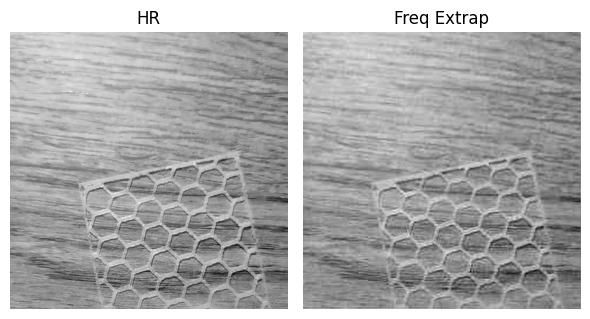

In [28]:
(hr_freq_v, freq_v) = freq_example

plt.figure(figsize=(6,4))

plt.subplot(1,2,1); plt.title("HR"); plt.imshow(hr_freq_v, cmap='gray'); plt.axis('off')
plt.subplot(1,2,2); plt.title("Freq Extrap"); plt.imshow(freq_v, cmap='gray'); plt.axis('off')

plt.tight_layout(); plt.show()

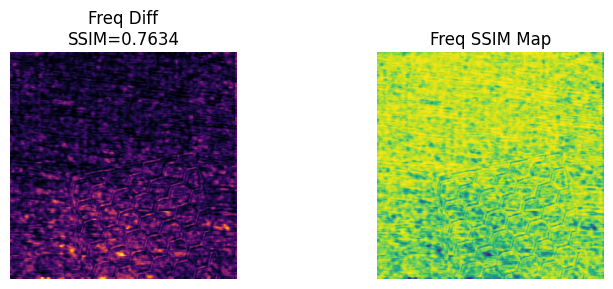

In [29]:
val_freq, ssim_map_freq = ssim(hr_freq_v, freq_v, data_range=255, full=True)
diff_freq = 1.0 - ssim_map_freq

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); plt.imshow(diff_freq, cmap='inferno'); plt.title(f'Freq Diff\nSSIM={val_freq:.4f}'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(ssim_map_freq); plt.title('Freq SSIM Map'); plt.axis('off')
plt.tight_layout(); plt.show()

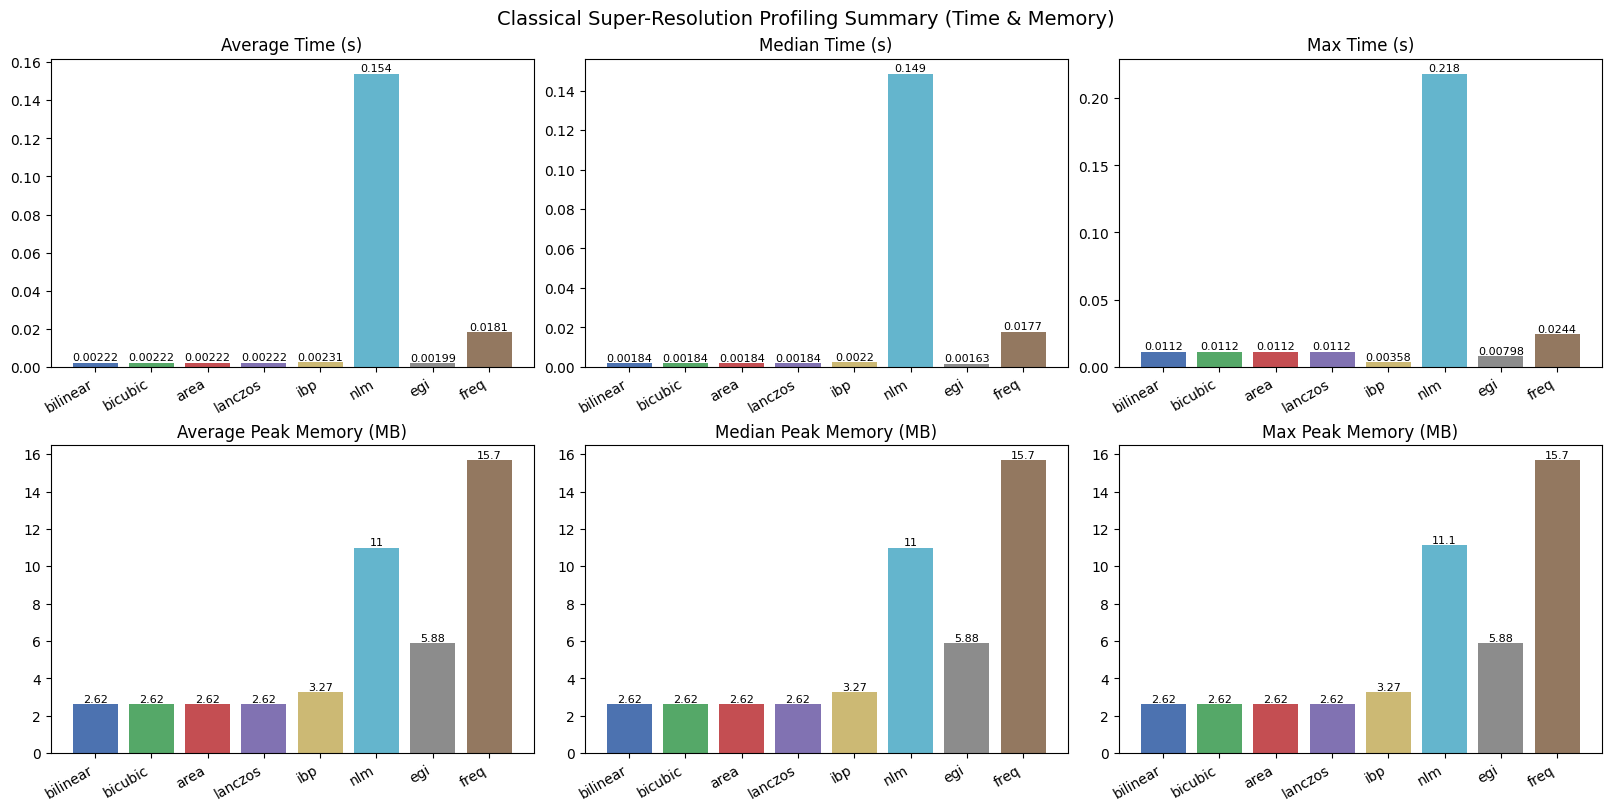

In [31]:
algorithms = ['bilinear','bicubic','area','lanczos','ibp','nlm','egi','freq']
colors = {
    'bilinear': '#4c72b0',
    'bicubic':  '#55a868',
    'area':     '#c44e52',
    'lanczos':  '#8172b2',
    'ibp':      '#ccb974',
    'nlm':      '#64b5cd',
    'egi':      '#8c8c8c',
    'freq':     '#937860',
}

def _safe_stats(values):
    if not values:
        return np.nan, np.nan, np.nan
    
    arr = np.array(values, dtype=float)
    
    return float(np.mean(arr)), float(np.median(arr)), float(np.max(arr))

time_mean, time_median, time_max = [], [], []
mem_mean, mem_median, mem_max = [], [], []

for alg in algorithms:
    t_mean, t_med, t_max = _safe_stats(time_stats_algorithms.get(alg, []))
    m_mean, m_med, m_max = _safe_stats(memory_stats_algorithms.get(alg, []))
    time_mean.append(t_mean)
    time_median.append(t_med)
    time_max.append(t_max)
    mem_mean.append(m_mean)
    mem_median.append(m_med)
    mem_max.append(m_max)

if all(np.isnan(time_mean)) and all(np.isnan(mem_mean)):
    print('No profiling data collected yet.')
else:
    # Convert memory from bytes to MB (MiB) for visualization
    to_mb = lambda arr: [v / (1024**2) if not np.isnan(v) else v for v in arr]
    mem_mean_mb = to_mb(mem_mean)
    mem_median_mb = to_mb(mem_median)
    mem_max_mb = to_mb(mem_max)

    x = np.arange(len(algorithms))
    fig, axes = plt.subplots(2, 3, figsize=(16, 8), constrained_layout=True)
    stat_sets = [
        (time_mean,      axes[0,0], 'Average Time (s)'),
        (time_median,    axes[0,1], 'Median Time (s)'),
        (time_max,       axes[0,2], 'Max Time (s)'),
        (mem_mean_mb,    axes[1,0], 'Average Peak Memory (MB)'),
        (mem_median_mb,  axes[1,1], 'Median Peak Memory (MB)'),
        (mem_max_mb,     axes[1,2], 'Max Peak Memory (MB)'),
    ]

    for data, ax, title in stat_sets:
        bars = ax.bar(x, data, color=[colors[a] for a in algorithms])
        ax.set_title(title)
        ax.set_xticks(x)
        ax.set_xticklabels(algorithms, rotation=30, ha='right')
        # Removed horizontal grid lines for a cleaner look
        for rect, val in zip(bars, data):
            if not np.isnan(val):
                ax.text(
                    rect.get_x() + rect.get_width()/2,
                    rect.get_height(),
                    f'{val:.3g}',
                    ha='center', va='bottom', fontsize=8
                )

    fig.suptitle('Classical Super-Resolution Profiling Summary (Time & Memory)', fontsize=14)
    out_path = Path('profiling_summary.png')
    fig.savefig(out_path, dpi=150)
    plt.show()